In [21]:
using Pkg
#Pkg.add("RegularExpressions")
using RegularExpressions
using Statistics
using Plots
using Pkg
Pkg.add("Colors")
using Colors

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [22]:
function extract_data(filename::AbstractString)
    data = zeros(Float64, 7, 4, 8, 5)

    current_thread = 0
    current_termination = 0
    current_size = 0
    current_time = 0.0
    
    i = 0
    j = 0
    k = 0
    l = 0


    open(filename, "r") do file
        for line in eachline(file)
            if occursin("threads", line)
                current_threads = filter(isdigit, line)
                i += 1
                j = 0
                k = 0
                l = 0
            elseif occursin("Running with n=", line)
                current_size = filter(isdigit, line)
                j += 1
                k = 0
                l = 0
            elseif occursin("Termination", line)
                current_termination = filter(isdigit, line)
                k += 1
                l = 0
            elseif occursin("elapsed time[s] ", line)
                l += 1
                parts = split(line, ",")
                current_time = parse(Float64, split(line, "elapsed time[s] ")[end])
                data[i, j, k, l] = current_time
            end
        end
    end

    return data
end

extract_data (generic function with 1 method)

In [23]:
data = extract_data("quicksort-51740151.out")

7×4×8×5 Array{Float64, 4}:
[:, :, 1, 1] =
 0.495847  0.805791  1.58475   3.12927
 0.275064  0.722684  1.25724   2.10092
 0.200083  0.420773  0.991725  1.83354
 0.174229  0.364424  0.876359  1.86098
 0.1637    0.372424  0.800857  1.30777
 0.175014  0.36789   0.72685   1.26167
 0.14317   0.333651  0.687879  1.23099

[:, :, 2, 1] =
 0.573771  0.833238  2.44199   3.65812
 0.325954  0.626046  1.26876   2.04389
 0.206813  0.413063  0.839363  1.6716
 0.188221  0.396793  0.849184  1.63914
 0.173303  0.340046  0.757425  1.29444
 0.160469  0.325528  0.715706  1.25016
 0.138484  0.303783  0.674411  1.13362

[:, :, 3, 1] =
 0.393303  0.6367    2.12534   3.4971
 0.301961  0.629969  1.29853   2.05156
 0.194265  0.396505  0.747189  1.57507
 0.177929  0.344327  0.857405  1.56778
 0.167828  0.337656  0.71716   1.20351
 0.167813  0.314427  0.700835  1.23797
 0.198737  0.353108  0.634305  1.1263

[:, :, 4, 1] =
 0.362226  0.815939  1.43732   3.98287
 0.312702  0.584071  1.03779   2.08834
 0.206976  0.387

In [24]:
# simulation data
threadsUsed = [2, 4, 6, 8, 10, 12, 16]
problemSizes = [5000000, 10000000, 20000000, 40000000]
terminationThreshold = [2, 5, 10, 15, 20, 25, 32, 40]
ideal = [i for i in 2:maximum(threadsUsed)]

# taken from separate run
baseline_data = [1.136709e+00 1.154810e+00 1.133336e+00 1.124856e+00 1.151862e+00;
                 2.407357e+00 2.294189e+00 2.335277e+00 2.187231e+00 2.137699e+00;
                 3.390565e+00 3.395374e+00 3.401969e+00 4.347291e+00 3.407502e+00;
                 6.108566e+00 7.798177e+00 9.186277e+00 7.980694e+00 8.302049e+00]

# take median and average of runs
medianData = median(data, dims=4)
medianBaseline = [median(baseline_data[i, :]) for i in 1:4]
averageData = mean(data, dims=4)
averageBaseline = [mean(baseline_data[i, :]) for i in 1:4]

medianSpeedup = [medianBaseline ./ medianData[i, :, j] 
                    for i in 1:length(threadsUsed), 
                        j in 1:length(terminationThreshold)]


7×8 Matrix{Vector{Float64}}:
 [2.13314, 2.65674, 1.65562, 2.43682]  …  [2.92917, 2.85882, 2.53968, 2.04508]
 [3.54061, 3.19498, 2.51829, 3.4351]      [3.71553, 3.9485, 3.20942, 3.87567]
 [5.65974, 5.066, 3.43035, 3.79082]       [5.80787, 5.95838, 3.70464, 5.10515]
 [5.95198, 5.54648, 3.59174, 4.28623]     [7.51553, 6.17602, 3.99855, 5.46063]
 [6.0092, 6.3912, 4.10977, 5.35058]       [6.86231, 6.81194, 4.84283, 6.06822]
 [6.26087, 6.08976, 4.44194, 5.83781]  …  [7.46561, 7.58191, 4.97551, 6.46235]
 [7.04044, 6.76742, 5.08199, 6.47014]     [7.95266, 7.6124, 5.41058, 8.40584]

In [25]:
palette = distinguishable_colors(length(terminationThreshold))
palette

In [26]:
# compare scaling for different threshholds
for i in 1:length(problemSizes)
    plot(ideal, ideal, xlabel="Threads Used", ylabel="Speedup", label="Ideal")
    xticks!(threadsUsed)
    for j in 1:length(terminationThreshold)
        color = palette[j]
        scatter!(threadsUsed, [v[i] for v in medianSpeedup[:, j]], label="Threshold = $(terminationThreshold[j])", marker= :+, color=color)
        plot!(threadsUsed, [v[i] for v in medianSpeedup[:, j]], label="", color=color)
    end
    savefig("plot $(problemSizes[i]).pdf")
end

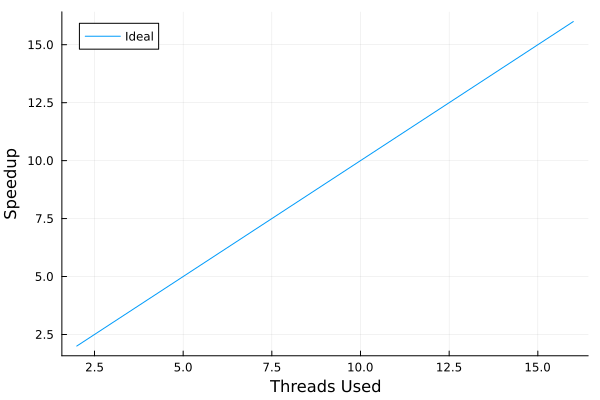

In [27]:
plot(ideal, ideal, xlabel="Threads Used", ylabel="Speedup", label="Ideal")